In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('data/train_dqd.csv')

In [8]:
df['q1_len'] = df['question1'].astype(str).apply(lambda x: x.split(' ')).apply(len)

In [9]:
df['q1_len'].head()

0    14
1     8
2    14
3    11
4    13
Name: q1_len, dtype: int64

In [10]:
import matplotlib.pyplot as plt

# We will use the Seaborn library
import seaborn as sns
sns.set()

# Graphics in retina format are more sharp and legible
%config InlineBackend.figure_format = 'retina'

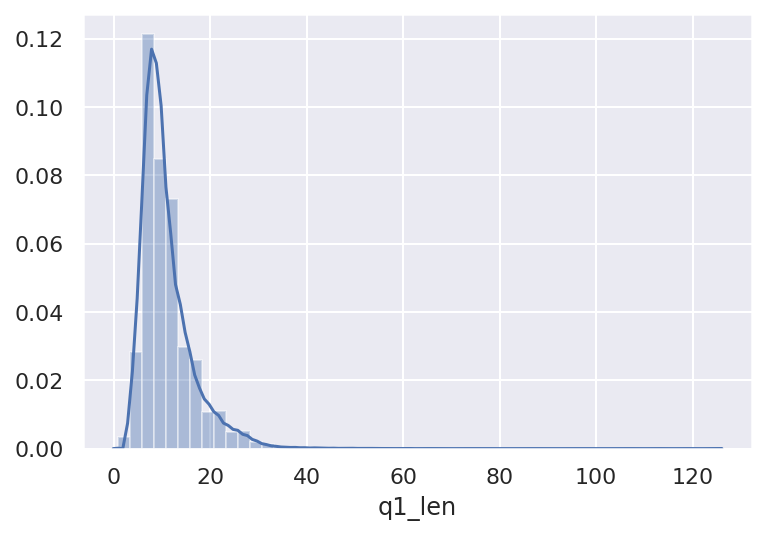

In [11]:
sns.distplot(df['q1_len'])

In [20]:
import spacy
import numpy as np
import pickle
import pandas as pd
from tqdm import tqdm

nlp = spacy.load('en_core_web_sm')

class PrepocessData:
    def __init__(self):
        pass

    def read_glove(self, file_path, dim=300):
        print('read glove')
        emb_dict = {}
        with open(file_path, encoding='utf-8') as f:
            for line in tqdm(f):
                tokens = line.strip().split(' ')
                emb_dict[tokens[0]] = list(map(lambda x: float(x), tokens[1:]))
        print('read glove over')
        return emb_dict

    def read_data(self, data_path, max_len =30):
        data_df = pd.read_csv(data_path)
        data_df = data_df[['id', 'question1', 'question2', 'is_duplicate']]
        data_df['question1'].apply(str)
        data_df['question1_len'] = data_df['question1'].apply(lambda x: min(max_len, len(x)))
        data_df['question2'].apply(str)
        data_df['question2_len'] = data_df['question2'].apply(lambda x: min(max_len, len(x)))
        data_df['id'].apply(str)
        data_df['is_duplicate'].apply(int)
        data = {
            "id": data_df['id'].values.tolist(),
            "question1": data_df['question1'].values.tolist(),
            "question2": data_df['question2'].values.tolist(),
            "question1_len": np.asarray(data_df['question1_len'].values.tolist(), dtype=np.int32),
            "question2_len": np.asarray(data_df['question2_len'].values.tolist(), dtype=np.int32),
            "label": np.asarray(data_df['is_duplicate'].values.tolist(), dtype=np.float32),
        }
        data['question1'] = list(map(self.tokenize_sentence, data['question1']))
        data['question2'] = list(map(self.tokenize_sentence, data['question2']))
        return data    
    def tokenize_sentence(self, sentence):
        if sentence is None:
            return []
        sentence = sentence.strip().replace('`',"'")
        doc = nlp.tokenizer(sentence)
        tokens = [token.lower_ for token in doc]
        return tokens

    def build_word_embedding_bysentetnce(self, sentence, pre_train_emb, word2Index, word_emb):
        for word in sentence:
            if word not in word2Index:
                if word in pre_train_emb:
                    word2Index[word] = len(word2Index)
                    word_emb.append(pre_train_emb[word])
                else:
                    pass
            else:
                pass    

    def build_word_embedding(self, data, pre_train_path, dim = 300):
        pre_train_emb = self.read_glove(pre_train_path)
        word2Index = {'PAD': 0, 'UNK':1}
        word_emb = [np.random.uniform(-0.1, 0.1, dim) for _ in range(2)]
        question1 = data["question1"]
        question2 = data["question2"]
        for i in tqdm(range(len(question1))):
            self.build_word_embedding_bysentetnce(question1[i], pre_train_emb, word2Index, word_emb)
            self.build_word_embedding_bysentetnce(question2[i], pre_train_emb, word2Index, word_emb)
        word_emb = np.asarray(word_emb, dtype='float32')
        return word_emb, word2Index

    def build_train_test_data(self, config):
        data = self.read_data(config.data_file_path)
        padded_data = self.padding_question(data, 30)
        word2Index = self.load_word2Index(config.word2Index_path)
        word_emb = self.load_word_emb(config.word_emb_path)
        self.transform_to_indices(data, word2Index)
        data_indexed = list(zip(data['question1'], data['question1_len'], data['question2'], data['question2_len'], data['label']))
        train_data, test_data = self.split_dataset(data_indexed)
        return train_data, test_data, word_emb

    def split_dataset(self, data):
        np.random.seed(123)
        np.random.shuffle(data)
        length = len(data)
        train_set = data[:int(length * 0.9)]
        test_set = data[int(length * 0.9): ]
        return train_set, test_set

    def transform_to_indices(self, data, word2Index):
        data['question1'] = list(map(lambda question: [word2Index.get(word, 1) for word in question], data['question1']))
        data['question2'] = list(map(lambda question: [word2Index.get(word, 1) for word in question], data['question2']))

    def padding_question(self, data, max_len=30):
        data['question1'] = list(map(lambda question: question[:max_len] + ['PAD'] * max(0, max_len - len(question)), data['question1']))
        data['question2'] = list(map(lambda question: question[:max_len] + ['PAD'] * max(0, max_len - len(question)), data['question2']))

    def save_word_emb(self, word_emb, word_emb_path):
        with open(word_emb_path, mode='wb') as f:
            pickle.dump(word_emb, f)
        print('word emb saved')

    def load_word_emb(self, word_emb_path):
        with open(word_emb_path, mode='rb') as f:
            word_emb = pickle.load(f)
        return word_emb
    
    def save_word2Index(self, word2Index, word2Index_path):
        with open(word2Index_path, mode='wb') as f:
            pickle.dump(word2Index, f)
        print('word2Index saved')

    def load_word2Index(self, word2Index_path):
        with open(word2Index_path, mode='rb') as f:
            word2Index = pickle.load(f)
        return word2Index
   


In [21]:
prepocess_data = PrepocessData()

In [22]:
import train
from models.biMPM import BIMPM
from models.esim import ESIM
from config import Config
import torch

In [23]:
config = Config()

In [24]:
train_data, test_data, word_emb = prepocess_data.build_train_test_data(config)

In [35]:
word_emb = torch.tensor(word_emb, dtype=torch.float,requires_grad=False).to(config.device)

In [36]:
config.n_vocab = len(word_emb)

In [70]:
import models.esim
import dataset_iterator
import utils
import imp
imp.reload(models.esim)
imp.reload(utils)
imp.reload(dataset_iterator)
from models.esim import ESIM

In [71]:
from dataset_iterator import DatasetIterator

In [72]:
train_iterator = DatasetIterator(train_data, config.batch_size, config.device)
test_iterator = DatasetIterator(test_data, config.batch_size, config.device)

In [73]:
model = ESIM(config.n_vocab, config.hidden_size, config.emb_dim, word_emb, config.n_classes, config.padding_idx, config.dropout, config.lstm_layer, config.device)

Seq2SeqEncoder input_size 300
Seq2SeqEncoder input_size 200


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [13]:
a = torch.rand(4,3, 2)
b= torch.rand(1,3, 2)

In [14]:
c =F.cosine_similarity(a, b, dim =-1)

In [15]:
c.size()

torch.Size([4, 3])

In [18]:
a = torch.rand(4,4, 6)

In [19]:
a

tensor([[[0.2156, 0.2269, 0.1982, 0.2186, 0.8822, 0.4786],
         [0.4274, 0.9836, 0.1181, 0.1014, 0.7548, 0.5529],
         [0.3305, 0.1201, 0.1877, 0.0476, 0.2950, 0.9884],
         [0.1239, 0.4881, 0.7369, 0.9669, 0.3797, 0.1264]],

        [[0.9164, 0.0751, 0.1254, 0.5563, 0.1609, 0.0268],
         [0.0772, 0.0474, 0.3034, 0.6345, 0.7949, 0.1048],
         [0.0649, 0.1473, 0.2948, 0.4719, 0.1453, 0.3159],
         [0.0084, 0.2595, 0.0371, 0.3839, 0.2291, 0.4502]],

        [[0.0198, 0.6461, 0.5706, 0.9315, 0.6931, 0.7113],
         [0.0265, 0.2278, 0.9299, 0.0391, 0.7781, 0.3325],
         [0.1637, 0.9106, 0.7197, 0.0071, 0.1658, 0.3913],
         [0.2570, 0.7387, 0.1775, 0.0534, 0.6075, 0.8725]],

        [[0.7111, 0.9511, 0.1751, 0.9115, 0.4607, 0.9743],
         [0.8646, 0.1437, 0.4807, 0.5408, 0.5377, 0.4163],
         [0.7986, 0.5797, 0.7862, 0.9538, 0.9909, 0.2586],
         [0.1362, 0.4527, 0.5664, 0.5680, 0.8672, 0.1423]]])

In [26]:
c = F.avg_pool1d(a, kernel_size=(4,1), stride=1)

RuntimeError: avg_pool1d() argument 'kernel_size' should contain one int (got 2)

In [27]:
a.mean(dim=1)

tensor([[0.2744, 0.4547, 0.3102, 0.3336, 0.5779, 0.5366],
        [0.2667, 0.1323, 0.1902, 0.5116, 0.3325, 0.2244],
        [0.1167, 0.6308, 0.5994, 0.2578, 0.5611, 0.5769],
        [0.6276, 0.5318, 0.5021, 0.7435, 0.7141, 0.4479]])

In [28]:
(0.2156 + 0.4274 + 0.3305 +0.1239) /4 

0.27435